# Idealized Case 2: Two crossing blobs

This tutorial explores the different methods of the linking process using an example of two crossing blobs. The following chapters will be covered:

1. [Data generation](#1.-Data-generation)
2. [Feature detection](#2.-Feature-detection)
3. [Influence of tracking method](#3.-Influence-of-the-tracking-method)
4. [Analysis](#4.-Analysis)

## 1. Data generation

We start by importing the usual libraries and adjusting some settings:

In [1]:
import tobac
import numpy as np
import matplotlib.pyplot as plt
import datetime
import xarray as xr
import seaborn as sns

sns.set_context("talk")
%matplotlib inline

We will need to generate our own dataset for this tutorial. For this reason we define some bounds for our system:

In [2]:
(
    x_min,
    y_min,
    x_max,
    y_max,
) = (
    0,
    0,
    1e5,
    1e5,
)
t_min, t_max = 0, 10000

We use these to create a mesh:

In [3]:
def create_mesh(x_min, y_min, x_max, y_max, t_min, t_max, N_x=200, N_y=200, dt=520):
    x = np.linspace(x_min, x_max, N_x)
    y = np.linspace(y_min, y_max, N_y)
    t = np.arange(t_min, t_max, dt)
    mesh = np.meshgrid(t, y, x, indexing="ij")

    return mesh


mesh = create_mesh(x_min, y_min, x_max, y_max, t_min, t_max)

Additionally, we need to set velocities for our blobs:

In [4]:
v_x = 10
v_y = 10

The dataset is created by using two functions. The first creates a wandering Gaussian blob as `numpy`-Array on our grid and the second transforms it into an `xarray`-DataArray with an arbitrary `datetime`.

In [5]:
def create_wandering_blob(mesh, x_0, y_0, v_x, v_y, t_create, t_vanish, sigma=1e7):
    tt, yy, xx = mesh
    exponent = (xx - x_0 - v_x * (tt - t_create)) ** 2 + (
        yy - y_0 - v_y * (tt - t_create)
    ) ** 2
    blob = np.exp(-exponent / sigma)
    blob = np.where(np.logical_and(tt >= t_create, tt <= t_vanish), blob, 0)

    return blob


def create_xarray(array, mesh, starting_time="2022-04-01T00:00"):
    tt, yy, xx = mesh
    t = np.unique(tt)
    y = np.unique(yy)
    x = np.unique(xx)

    N_t = len(t)
    dt = np.diff(t)[0]

    t_0 = np.datetime64(starting_time)
    t_delta = np.timedelta64(dt, "s")

    time = np.array([t_0 + i * t_delta for i in range(len(array))])

    dims = ("time", "projection_x_coordinate", "projection_y_coordinate")
    coords = {"time": time, "projection_x_coordinate": x, "projection_y_coordinate": y}
    attributes = {"units": ("m s-1")}

    data = xr.DataArray(data=array, dims=dims, coords=coords, attrs=attributes)
    # data = data.projection_x_coordinate.assign_attrs({"units": ("m")})
    # data = data.projection_y_coordinate.assign_attrs({"units": ("m")})
    data = data.assign_coords(latitude=("projection_x_coordinate", x / x.max() * 90))
    data = data.assign_coords(longitude=("projection_y_coordinate", y / y.max() * 90))

    return data

We use the first function to create two blobs whose paths will cross. To keep them detectable as seperate features in the dataset we don't want to just add them together. Instead we are going to use the highest value of each pixel by applying boolean masking and the resulting field is transformed into the `xarray` format.

In [6]:
blob_1 = create_wandering_blob(mesh, x_min, y_min, v_x, v_y, t_min, t_max)
blob_2 = create_wandering_blob(mesh, x_max, y_min, -v_x, v_y, t_min, t_max)
blob_mask = blob_1 > blob_2
blob = np.where(blob_mask, blob_1, blob_2)

data = create_xarray(blob, mesh)

/var/folders/bj/m6g82c6n41g83y3_dx02y7ch0000gp/T/ipykernel_94433/598173551.py:30: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  data = xr.DataArray(data=array, dims=dims, coords=coords, attrs=attributes)


Let's check if we achived what we wanted by plotting the result:

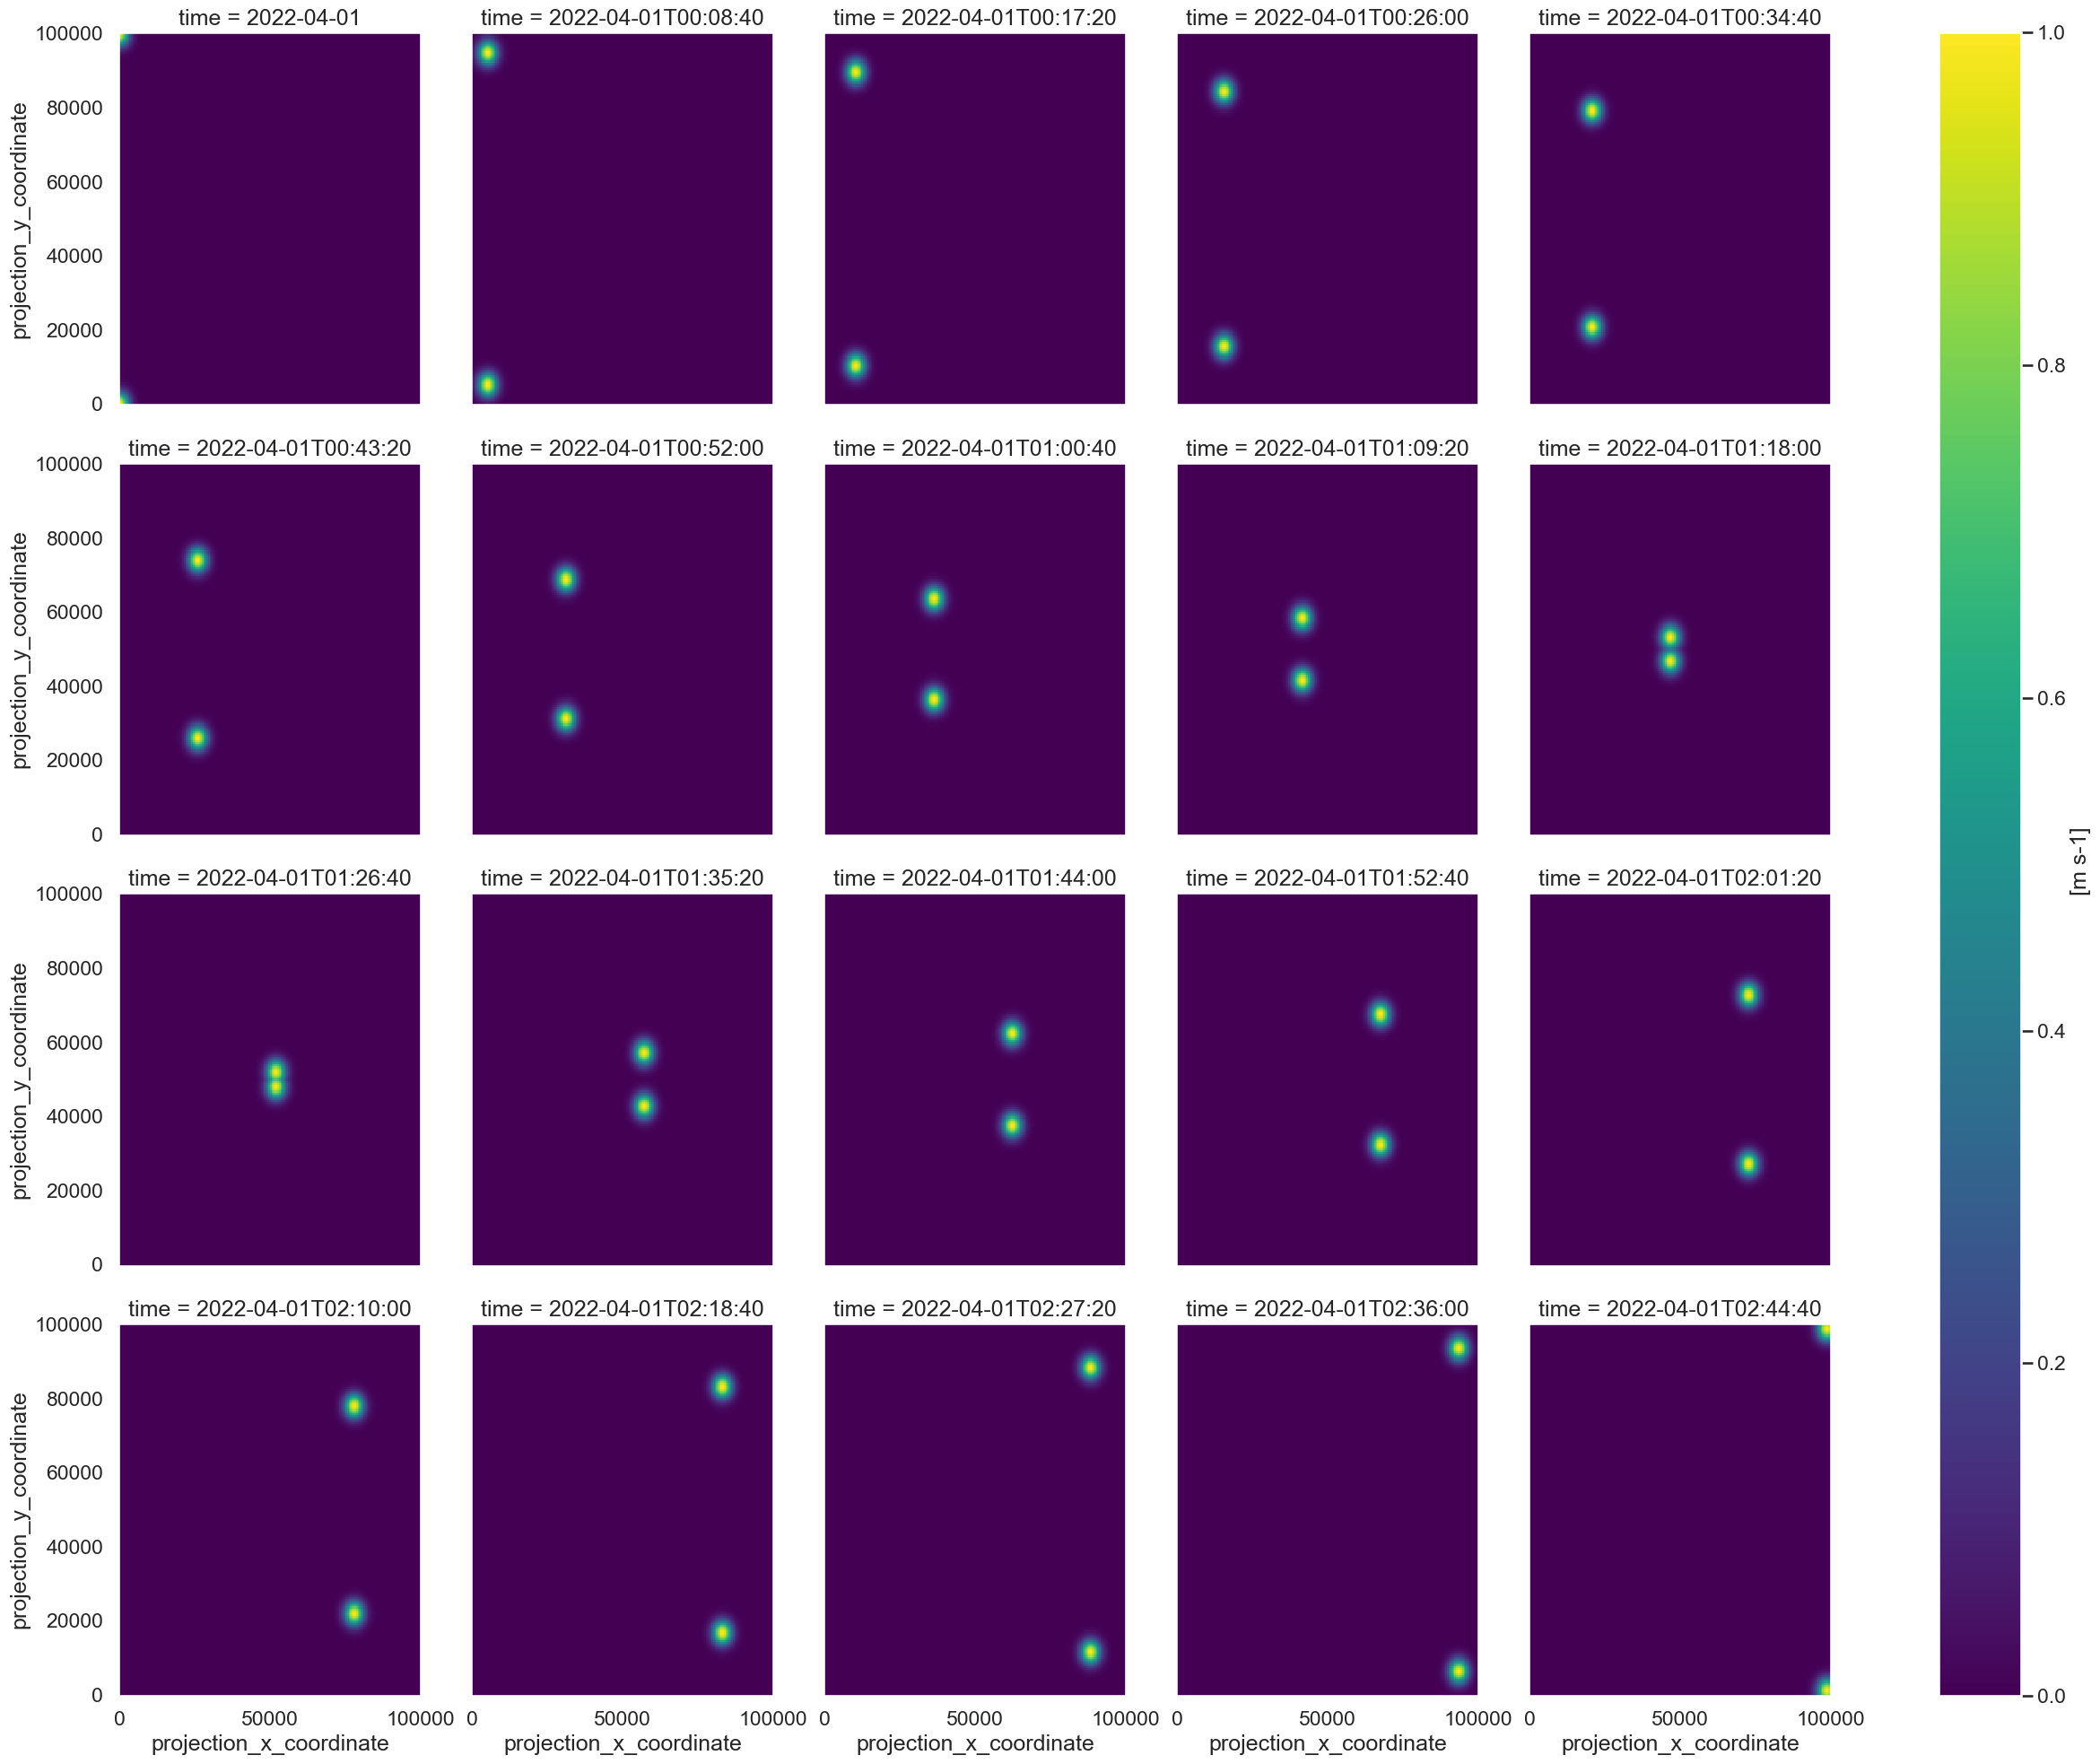

In [7]:
data.plot(
    cmap="viridis",
    col="time",
    col_wrap=5,
    x="projection_x_coordinate",
    y="projection_y_coordinate",
    size=5,
)

Looks good! We see two features crossing each other, and they are clearly separable in every frame.

## 2. Feature detection

Before we can perform the tracking we need to detect the features with the usual function. The grid spacing is deduced from the generated field. We still need to find a reasonable threshold value. Let's try a really high one:

In [8]:
%%capture

spacing = np.diff(np.unique(mesh[1]))[0]

dxy, dt = tobac.get_spacings(data, grid_spacing=spacing)
features = tobac.feature_detection_multithreshold(data, dxy, threshold=0.99)

<Axes: xlabel='hdim_1', ylabel='hdim_2'>

<Figure size 1000x600 with 0 Axes>

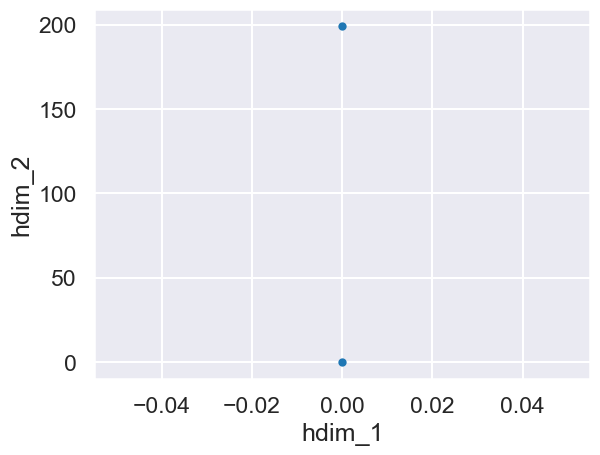

In [9]:
plt.figure(figsize=(10, 6))
features.plot.scatter(x="hdim_1", y="hdim_2")

As you can see almost no features are detected. This means our threshold is too high and neglects many datapoints. Therefore it is a good idea to try a low threshold value:

In [10]:
%%capture
features = tobac.feature_detection_multithreshold(data, dxy, threshold=0.3)

<Axes: xlabel='hdim_1', ylabel='hdim_2'>

<Figure size 1000x600 with 0 Axes>

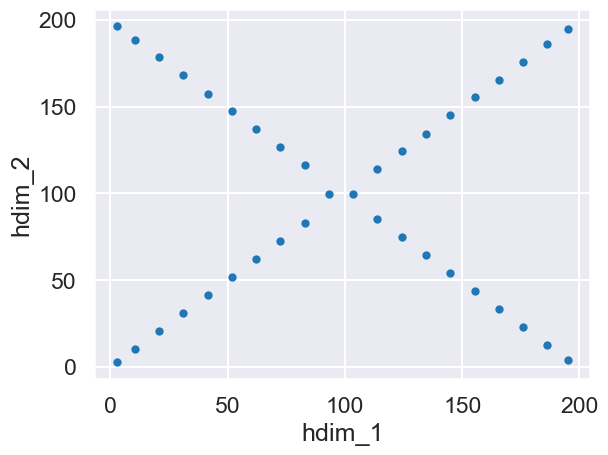

In [11]:
plt.figure(figsize=(10, 6))
features.plot.scatter(x="hdim_1", y="hdim_2")

Here the paths of the blobs are clearly visible, but there is an area in the middle where both merge into one feature. This should be avoided. Therefore we try another value for the threshold somewhere in the middle of the available range:

In [12]:
%%capture
features = tobac.feature_detection_multithreshold(data, dxy, threshold=0.8)

<Axes: xlabel='hdim_1', ylabel='hdim_2'>

<Figure size 1000x600 with 0 Axes>

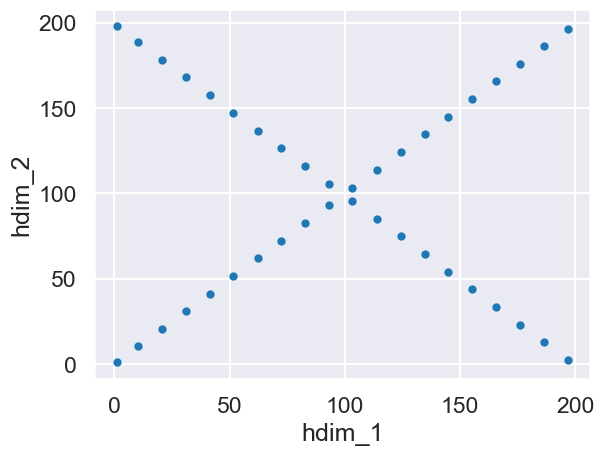

In [13]:
plt.figure(figsize=(10, 6))
features.plot.scatter(x="hdim_1", y="hdim_2")

This is the picture we wanted to see. This means we can continue working with this set of features.

## 3. Influence of the tracking method

Now the tracking can be performed. We will create two outputs, one with `method = 'random'`, and the other one with `method = 'predict'`. Since we know what the velocities of our features are beforehand, we can select a reasonable value for `v_max`. Normally this would need to be finetuned.

In [14]:
%matplotlib inline
v_max = 20

track_1 = tobac.linking_trackpy(
    features, data, dt, dxy, v_max=v_max, method_linking="random"
)

track_2 = tobac.linking_trackpy(
    features, data, dt, dxy, v_max=v_max, method_linking="predict"
)

Frame 19: 2 trajectories present.


In [15]:
track_1

,frame,idx,hdim_1,hdim_2,num,threshold_value,feature,time,timestr,projection_x_coordinate,projection_y_coordinate,latitude,longitude,cell,time_cell
0,0,1,1.000000,1.000000,9,0.8,1,2022-04-01 00:00:00,2022-04-01 00:00:00,502.512563,502.512563,0.452261,0.452261,1,0 days 00:00:00
1,0,2,1.000000,198.000000,9,0.8,2,2022-04-01 00:00:00,2022-04-01 00:00:00,502.512563,99497.487437,0.452261,89.547739,2,0 days 00:00:00
2,1,1,10.321429,10.321429,28,0.8,3,2022-04-01 00:08:40,2022-04-01 00:08:40,5186.647523,5186.647523,4.667983,4.667983,1,0 days 00:08:40
3,1,2,10.321429,188.678571,28,0.8,4,2022-04-01 00:08:40,2022-04-01 00:08:40,5186.647523,94813.352477,4.667983,85.332017,2,0 days 00:08:40
4,2,1,20.678571,20.678571,28,0.8,5,2022-04-01 00:17:20,2022-04-01 00:17:20,10391.241924,10391.241924,9.352118,9.352118,1,0 days 00:17:20
5,2,2,20.678571,178.321429,28,0.8,6,2022-04-01 00:17:20,2022-04-01 00:17:20,10391.241924,89608.758076,9.352118,80.647882,2,0 days 00:17:20
6,3,1,31.000000,31.000000,25,0.8,7,2022-04-01 00:26:00,2022-04-01 00:26:00,15577.889447,15577.889447,14.020101,14.020101,1,0 days 00:26:00
7,3,2,31.000000,168.000000,25,0.8,8,2022-04-01 00:26:00,2022-04-01 00:26:00,15577.889447,84422.110553,14.020101,75.979899,2,0 days 00:26:00
9,4,2,41.321429,157.678571,28,0.8,10,2022-04-01 00:34:40,2022-04-01 00:34:40,20764.536971,79235.463029,18.688083,71.311917,2,0 days 00:34:40
8,4,1,41.321429,41.321429,28,0.8,9,2022-04-01 00:34:40,2022-04-01 00:34:40,20764.536971,20764.536971,18.688083,18.688083,1,0 days 00:34:40


Let's have a look at the resulting tracks:

Text(0.5, 1.0, 'predict')

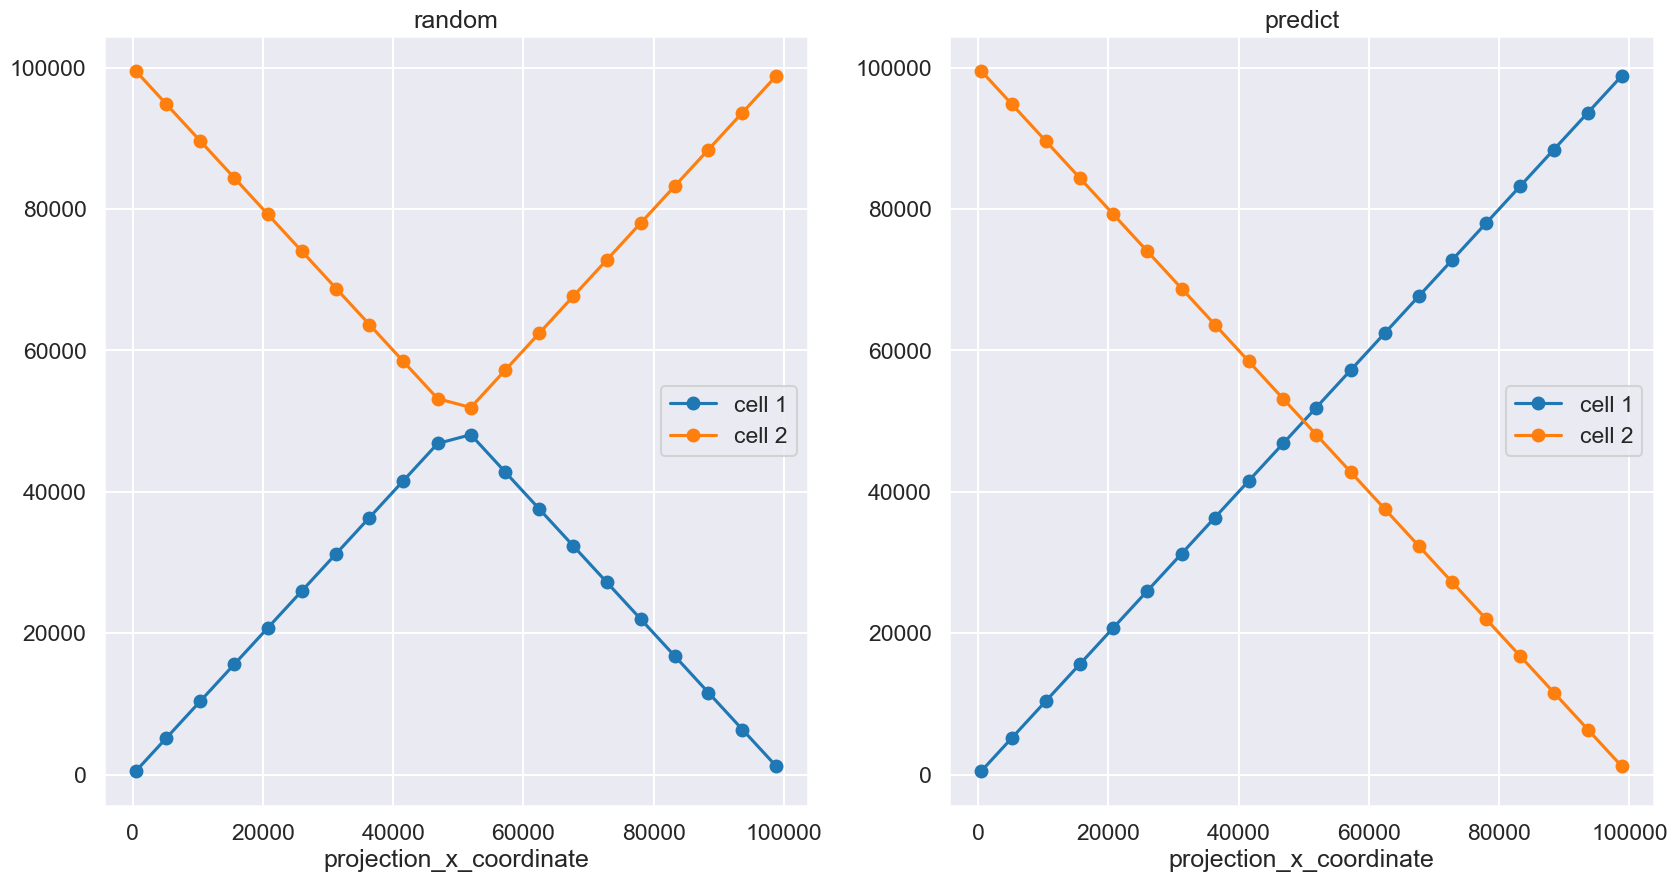

In [16]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 10))

cell_color = [None, "C0", "C1", "C2", "C3"]
for i, cell_track in track_1.groupby("cell"):
    cell_track.plot(
        x="projection_x_coordinate",
        y="projection_y_coordinate",
        ax=ax1,
        marker="o",
        color=cell_color[i],
        label="cell {0}".format(int(i)),
    )
ax1.legend()
ax1.set_title("random")

for i, cell_track in track_2.groupby("cell"):
    cell_track.plot(
        x="projection_x_coordinate",
        y="projection_y_coordinate",
        ax=ax2,
        marker="o",
        color=cell_color[i],
        label="cell {0}".format(int(i)),
    )
ax2.legend()
ax2.set_title("predict")

As you can see, there is a clear difference. While in the first link output the feature positions in the top half of the graph are linked into one cell, in the second output the path of the cell follows the actual way of the Gaussian blobs we created. This is possible because `method = "predict"` uses an extraploation to infer the next position from the previous timeframes.

## 4. Analysis

We know that the second option is "correct", because we created the data. But can we also decude this by analyzing our tracks?

Let's calculate the values for the velocities:

In [17]:
track_1 = tobac.analysis.calculate_velocity(track_1)
track_2 = tobac.analysis.calculate_velocity(track_2)

v1 = track_1.where(track_1["cell"] == 1).dropna().v.values
v2 = track_2.where(track_1["cell"] == 1).dropna().v.values

Visualizing these can help us with our investigation:

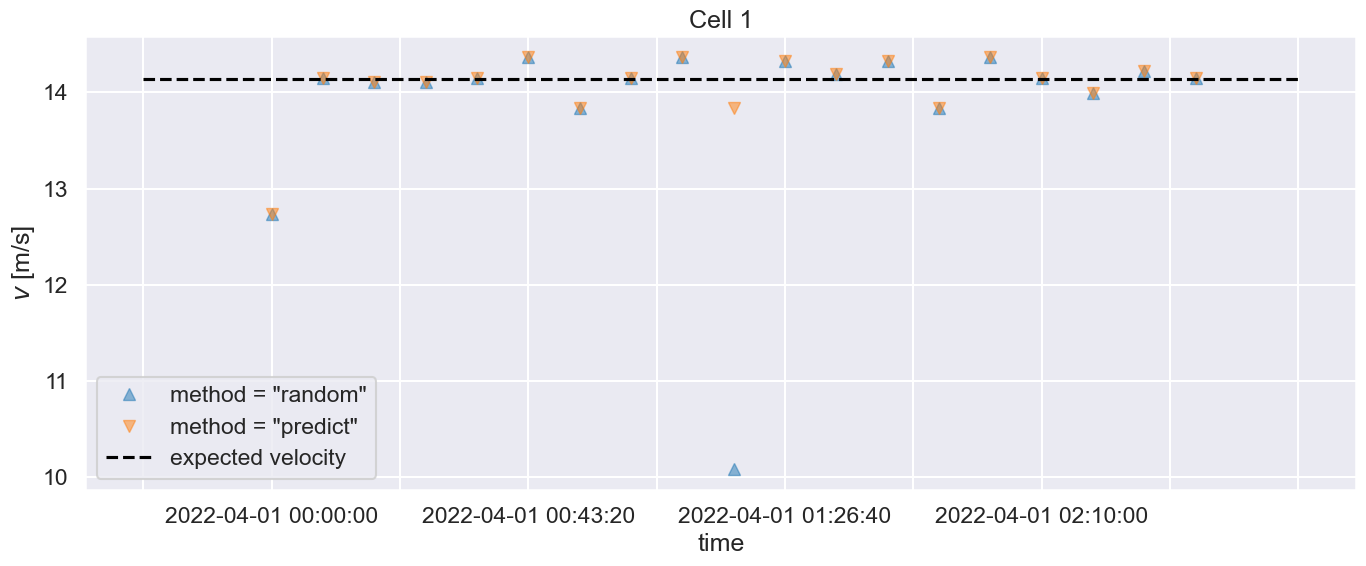

In [18]:
fig, (ax) = plt.subplots(figsize=(14, 6))

ax.set_title("Cell 1")

mask_1 = track_1["cell"] == 1
mask_2 = track_2["cell"] == 1

track_1.where(mask_1).dropna().plot(
    x="time",
    y="v",
    ax=ax,
    label='method = "random"',
    marker="^",
    linestyle="",
    alpha=0.5,
)
track_2.where(mask_2).dropna().plot(
    x="time",
    y="v",
    ax=ax,
    label='method = "predict"',
    marker="v",
    linestyle="",
    alpha=0.5,
)

ticks = ax.get_xticks()

plt.hlines(
    [np.sqrt(v_x**2 + v_y**2)],
    ticks.min(),
    ticks.max(),
    color="black",
    label="expected velocity",
    linestyle="--",
)


ax.set_ylabel("$v$ [m/s]")
plt.legend()
plt.tight_layout()

The expected velocity is just added for reference. But also without looking at this, we can see that the values for `method = "random"` have an outlier, that deviates far from the other values. This is a clear sign, that this method is not suited well for this case.